In [2]:
from collections import defaultdict

import pybedtools
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats

import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scripts import aesthetics
from scripts import manuscript_colors as mc

aesthetics.activate_paper_rcParams('illustrator')

# GTEX analysis

This notebook is dedicated to exploring the expression of genes affected by SVs in our samples.

# Load SV-related data

We need to load all the SVs and the genes they affect.

In [3]:
# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.4.cohort_metadata.w_control_assignments.tsv.gz"
gene_ref_path = "data/gencode_hg38_protein_coding_genes_for_annotation.txt"

In [4]:
gene_ref = pd.read_csv(gene_ref_path)
gene_ref = gene_ref[~gene_ref["value"].str.startswith("ENSG00")]
gene_ref = sorted(set(gene_ref["value"].tolist()))
len(gene_ref)

19201

## Metadata and reference counts

Load metadata and SVs

In [5]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
samples = defaultdict(dict)

total_samples = []
for disease in ["neuroblastoma", "ewing"]:
    for cohort in ["case", "control"]:
        disease_cohort_samples = metadata[(metadata[f"{disease}_{cohort}"] == True)][
            "entity:sample_id"
        ].tolist()

        samples[disease][cohort] = disease_cohort_samples
        total_samples += disease_cohort_samples

        print(disease, cohort, len(disease_cohort_samples))

total_samples = sorted(set(total_samples))

neuroblastoma case 688
neuroblastoma control 4830
ewing case 772
ewing control 4575


In [6]:
len(total_samples)

6431

Now we load the SVs. These are reference counts generated in `cwas-gene-set-enrichment`

In [7]:
ref_counts = pd.read_csv("data/cwas/reference-counts.csv")
ref_counts = ref_counts[ref_counts['gene'].isin(gene_ref)]

In [8]:
ref_counts.head(2)

,name,dose,gene,disease,sv_category,cohort
0,PedSV.2.5.2_DEL_chr1_80,0,SAMD11,neuroblastoma,coding,case
1,PedSV.2.5.2_DEL_chr1_100,1,KLHL17,neuroblastoma,coding,case


## Add a label for various SV traits

We add some traits to the SVs defined in these files based on the original vcf

In [9]:
sv_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.4.full_cohort.analysis_samples.sites.bed.gz"
sv_cols = pd.read_csv(sv_path, sep = '\t', nrows = 0)

# in particular, we want whether the SVs are singletons in this analysis
cols_to_include = ['name', 'AC', 'gnomad_v3.1_sv_POPMAX_AF']
cols_to_include_idx = [i for i, c in enumerate(sv_cols.columns) if c in cols_to_include]

svs = pd.read_csv(sv_path, sep = '\t', usecols = cols_to_include_idx)

In [10]:
svs.head(2)

,name,AC,gnomad_v3.1_sv_POPMAX_AF
0,PedSV.2.5.2_CNV_chr1_1,0,NaN
1,PedSV.2.5.2_DUP_chr1_1,356,0.222174


An SV is a true singleton if it's allele count is 1 across all the samples (cases and controls) and its AF in gnomad is < 0.01

In [11]:
singleton_svs = svs[(svs['AC'] == 1) & (svs['gnomad_v3.1_sv_POPMAX_AF'].fillna(0) < 0.01)]['name']

In [12]:
ref_counts['global_singleton'] = ref_counts['name'].isin(singleton_svs)

## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files.

In [13]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/cwas/svs-in-categories/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t")
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,neuroblastoma,coding
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,neuroblastoma,coding


In [14]:
#########################
### FRAMEWORK RESULTS ###
#########################
columns = ['category_name', 'point_estimate', 'std_error', 'z_score', 'p_value']
framework_results = []
for file in glob.glob("data/cwas/summary-stats/*.txt"):

    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t", usecols = columns)
    data[["disease", "sv_category"]] = [
        disease,
        sv_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)
framework_results['negative_log10_p_value'] = -np.log10(framework_results['p_value'])

In [15]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/cwas/schema/*.txt"):

    sv_category = "noncoding" if "noncoding" in file else "coding"
    suffix = file.split("/")[-1]
    if sv_category == "coding":
        disease = suffix.split('_')[2]
    else:
        disease = suffix.split('_')[3]

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

In [16]:
framework_schema["ewing"]["noncoding"].head(2)

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,ewing_and_osteosarcoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_muscle_skeletal,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,ewing_chromHMM15_EnhBiv,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs


# Define GTEX data

Taken from https://www.gtexportal.org/home/downloads/adult-gtex/bulk_tissue_expression

In [17]:
gtex = pd.read_csv('data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz', comment = '#', sep = '\t', skiprows = 2).rename(columns = {'Description': 'gene'})
gtex.head(2)

,Name,gene,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,ENSG00000223972.5,DDX11L1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.166403,0.00000,0.00000,0.00000,0.00000
1,ENSG00000227232.5,WASH7P,4.06403,3.37111,2.68549,4.04762,3.90076,3.63963,5.16375,1.43859,...,5.93298,6.13265,4.19378,5.92631,3.06248,4.702530,6.27255,7.19001,5.74554,2.64743


Because we dropped genes with ENGS ids in our cohort, we repeat the same here, only keeping genes present in our GTF.

In [18]:
# drop ENGS ids
gtex = gtex.iloc[:, 1:]

gtex = gtex[gtex['gene'].isin(gene_ref)]

gtex = gtex.set_index('gene')

# genes need expression in at least 10% of histologies
gtex = gtex[(gtex != 0).mean(axis = 1) > 0.10]

In [19]:
gtex.shape

(17162, 54)

## Examine absolute expression

We examine the GTEX expression of genes affected by SVs in our dataset. We start by identifying the true singletons.

In [20]:
singleton_coding_ref_exp = ref_counts.query('dose == 1 & sv_category == "coding" & global_singleton == True')
singleton_coding_ref_exp = singleton_coding_ref_exp.merge(gtex.reset_index(), on = 'gene')

We next identify the genes that are affected by cases, controls, unique to cases, and unique to controls. For each, store the expression.

In [21]:
tpm_violin_data = []

# use Adrenal Gland for neuroblastoma and Skeletal Muscle for ewing
for disease, tissue in zip(['neuroblastoma', 'ewing'], 
                           ['Adrenal Gland', 'Muscle - Skeletal']):
    
    # get the disease SVs - nbl or ewing
    disease_data = singleton_coding_ref_exp.query(f'disease == "{disease}"').copy()
    
    # identify the genes unique to cases or controls
    for cohort in ['control', 'case']:
        cohort_data = disease_data.query(f'cohort == "{cohort}"')[['gene', tissue, 'disease', 'cohort', 'name']]
        cohort_data = cohort_data.rename(columns = {tissue: 'tissue'})
        tpm_violin_data.append(cohort_data)
        
        # next, subtract out the "other" cohort to get the genes uniquely affected by SVs in this cohort
        other = 'control' if cohort == 'case' else 'case'
        other_data = disease_data.query(f'cohort == "{other}"')
        other_unique = cohort_data[~cohort_data['gene'].isin(other_data['gene'].tolist())].copy()
        other_unique['cohort'] = f'{cohort}_unique'
        tpm_violin_data.append(other_unique)
        
tpm_violin_data = pd.concat(tpm_violin_data)
tpm_violin_data['logTPM'] = np.log10(tpm_violin_data['tissue'] + 1)

In [22]:
tpm_violin_data.head(2)

,gene,tissue,disease,cohort,name,logTPM
3,DVL1,64.19010,neuroblastoma,control,PedSV.2.5.2_DEL_chr1_258,1.814182
11,NPHP4,4.73534,neuroblastoma,control,PedSV.2.5.2_DEL_chr1_1128,0.758559


Now we make Figure 4d. We define a color palette:

In [23]:
palette = {'neuroblastoma': {'control': 'lightgrey', 
                             'case': mc.palette['neuroblastoma']['light2'],
                             'case_unique': mc.palette['neuroblastoma']['main'],
                             'control_unique': 'darkgrey'},
           'ewing': {'control': 'lightgrey', 
                     'control_unique': 'darkgrey',
                     'case': mc.palette['ewing']['light2'],
                     'case_unique': mc.palette['ewing']['main']}
          }

And make the figure

neuroblastoma control 3.73612 0.6754226976586122 4.73612
neuroblastoma control_unique 3.938185 0.6935673363061667 4.938184999999999
neuroblastoma case 4.52763 0.7425365695483572 5.527629999999999
neuroblastoma case_unique 5.83523 0.8347531328102417 6.83523
MannwhitneyuResult(statistic=796982.0, pvalue=0.000560110190651271)
ewing control 1.60004 0.41498002937299044 2.60004
ewing control_unique 1.6704 0.4265763193351715 2.6704
ewing case 1.8452 0.454112800025813 2.8452
ewing case_unique 2.303925 0.5190147448340754 3.303925
MannwhitneyuResult(statistic=907522.0, pvalue=0.04118804864459514)


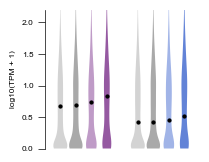

In [24]:
fig, axes = plt.subplots(1, 2, figsize = (2.0, 1.8), gridspec_kw = {'wspace': 0}, sharey = True)

for i, disease in enumerate(['neuroblastoma', 'ewing']):
    ax = axes[i]

    # look up the disease data
    disease_data = tpm_violin_data.query(f'disease == "{disease}"')
    
    pal = palette[disease]

    # make the violin plot
    violin = sns.violinplot(x = 'cohort', y = 'logTPM', data = tpm_violin_data, ax = ax,
                            order = ['control', 'control_unique', 'case', 'case_unique'], width = 0.9, linewidth=0, 
                            cut = 0, palette = pal)
    
    # add median expression
    tpms = []
    for j, cohort in enumerate(['control', 'control_unique', 'case', 'case_unique']):
        cohort_data = disease_data.query(f'cohort == "{cohort}"')
        
        median = cohort_data['logTPM'].median()
        ax.scatter([j], [median], s = 5, color = 'black')
        
        tpms.append(cohort_data['logTPM'])
        
        print(disease, cohort, cohort_data['tissue'].median(), median, (10**cohort_data['logTPM']).median())

    p = stats.mannwhitneyu(tpms[1], tpms[3])
    print(p)
    
    ax.set_ylim([0, 2.2])
    ax.set_xlim([-1, 4])
    ax.set_ylabel('log10(TPM + 1)')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
    if i == 0:
        aesthetics.strip_axis(ax = ax, y = 'ignore', x = 'label')
        
    else:
        aesthetics.strip_axis(ax = ax, x = 'label')
        
fig.savefig('figures/fig4d.pdf', bbox_inches = 'tight')

In [25]:
cohort_data

,gene,tissue,disease,cohort,name,logTPM
74,SLC39A1,22.895600,ewing,case_unique,PedSV.2.5.2_DUP_chr1_2813,1.378318
232,MROH2A,0.000000,ewing,case_unique,PedSV.2.5.2_DEL_chr2_15309,0.000000
271,SLC12A8,0.060232,ewing,case_unique,PedSV.2.5.2_DEL_chr3_7661,0.025401
273,OSBPL11,42.897400,ewing,case_unique,PedSV.2.5.2_DEL_chr3_7695,1.642439
275,ACAD11,7.267370,ewing,case_unique,PedSV.2.5.2_DUP_chr3_2075,0.917367
...,...,...,...,...,...,...
9501,RHOXF1,0.121025,ewing,case_unique,PedSV.2.5.2_DUP_chrX_2387,0.049615
9502,TMEM255A,0.271272,ewing,case_unique,PedSV.2.5.2_DUP_chrX_2387,0.104238
9503,TREX2,0.177207,ewing,case_unique,PedSV.2.5.2_DUP_chrX_2864,0.070853
9504,HAUS7,0.312079,ewing,case_unique,PedSV.2.5.2_DUP_chrX_2864,0.117960


For the supplementa, we repeat for other tissues, focusing on control and case unique

In [26]:
tissues = ['Adrenal Gland', 'Brain - Cortex', 'Breast - Mammary Tissue', 'Colon - Transverse', 'Heart - Left Ventricle', 
           'Kidney - Cortex', 'Liver', 'Lung', 'Muscle - Skeletal', 'Pancreas', 'Prostate', 'Skin - Sun Exposed (Lower leg)', 'Whole Blood']
tissue_names = ['Adrenal\ngland', 'Brain', 'Breast', 'Colon', 'Heart', 'Kidney', 'Liver', 'Lung', 'Skeletal\nmuscle', 'Pancreas', 'Prostate', 'Skin', 'Blood']

In [27]:
tpm_violin_data_all_tissues = []

for disease in ['neuroblastoma', 'ewing']:
    disease_data = singleton_coding_ref_exp.query(f'disease == "{disease}"').copy()
    
    for t in tissues:

        for cohort in ['control', 'case']:
            cohort_data = disease_data.query(f'cohort == "{cohort}"')[['gene', t, 'disease', 'cohort', 'name']]
            cohort_data = cohort_data.rename(columns = {t: 'value'})
            cohort_data['tissue'] = t
            tpm_violin_data_all_tissues.append(cohort_data)

            # next, subtract out the "other" cohort to get the genes uniquely affected by SVs in this cohort
            other = 'control' if cohort == 'case' else 'case'
            other_data = disease_data.query(f'cohort == "{other}"')
            other_unique = cohort_data[~cohort_data['gene'].isin(other_data['gene'].tolist())].copy()
            other_unique['cohort'] = f'{cohort}_unique'
            tpm_violin_data_all_tissues.append(other_unique)
                
tpm_violin_data_all_tissues = pd.concat(tpm_violin_data_all_tissues)
tpm_violin_data_all_tissues['logTPM'] = np.log10(tpm_violin_data_all_tissues['value'] + 1)

tpm_violin_data_all_tissues = tpm_violin_data_all_tissues[tpm_violin_data_all_tissues['cohort'].isin(['control_unique', 'case_unique'])]

In [28]:
tpm_violin_data_all_tissues.head(2)

,gene,value,disease,cohort,name,tissue,logTPM
1583,C1QTNF12,0.643373,neuroblastoma,control_unique,PedSV.2.5.2_DEL_chr1_210,Adrenal Gland,0.215736
1585,CPTP,23.840300,neuroblastoma,control_unique,PedSV.2.5.2_DEL_chr1_248,Adrenal Gland,1.395157


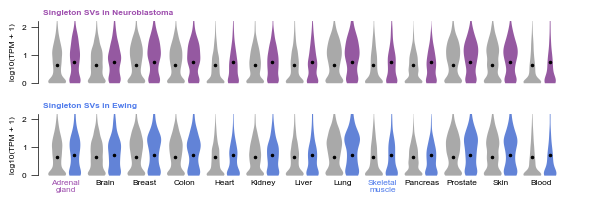

In [29]:
fig, axes = plt.subplots(2, 1, figsize = (7, 2), gridspec_kw = {'hspace': 0.5}, sharey = True)

for i, disease in enumerate(['neuroblastoma', 'ewing']):
    ax = axes[i]

    disease_data = tpm_violin_data_all_tissues.query(f'disease == "{disease}"')
    
    pal = palette[disease]

    violin = sns.violinplot(x = 'tissue', y = 'logTPM', data = disease_data, ax = ax, hue = 'cohort', dodge = True,
                            order = tissues, width = 0.9, linewidth=0, 
                            cut = 0, palette = pal)
    
    ax.legend().remove()
    
    tpms = []
    for j, tissue in enumerate(tissues):
        for k, cohort in enumerate(['control_unique', 'case_unique']):
            cohort_data = disease_data.query(f'cohort == "{cohort}"')

            median = cohort_data['logTPM'].median()
            ax.scatter([j - 0.225 + 0.45 * k], [median], s = 3, color = 'black')
    
    ax.set_ylim([0, 2.2])
    ax.set_xlim([-0.7, len(tissues)])
    ax.set_ylabel('log10(TPM + 1)')
    
    if i == 0:
        aesthetics.strip_axis(ax = ax, y = 'ignore')
    else:
        sns.despine(ax = ax, bottom = True)
        ax.tick_params(axis = 'x', length = 0)
        text = ax.set_xticklabels(tissue_names)
        ax.set_xlabel('')
        
        for t in text:
            if t.get_text() == 'Adrenal\ngland':
                t.set_color(mc.palette['neuroblastoma']['main'])
            elif t.get_text() == 'Skeletal\nmuscle':
                t.set_color(mc.palette['ewing']['main'])
        
    ax.text(s = 'Singleton SVs in ' + disease.capitalize(), color = mc.palette[disease]['main'], weight = 'bold', x = 0.01, y = 1.1, transform = ax.transAxes)
            
fig.savefig('figures/overall-gtex-expression-s8.pdf', bbox_inches = 'tight')

# Revision

For the revision, we're going to compare expression of genes in adrenal TADs vs outside adrenal TADs across various tissues. Let's see what this looks like.

In [30]:
tad_locations = pd.read_csv('data/Gene_TAD_table_7_4_24.tsv', sep = '\t')
tad_locations['gene_mean'] = tad_locations[['gene_start', 'gene_end']].mean(axis = 1)

# add in a metric for how far the gene is from the tad boundaries
distance_to_bp1 = np.abs(tad_locations['gene_mean'] - tad_locations['TAD_bp1'])
distance_to_bp2 = np.abs(tad_locations['gene_mean'] - tad_locations['TAD_bp2'])

tad_locations['distance_to_tad_bp'] = np.min([distance_to_bp1, distance_to_bp2], axis = 0)

# convert this metric to a rank
tad_locations['rank_dist_to_tad_bp'] = 1 - stats.rankdata(tad_locations['distance_to_tad_bp']) / len(tad_locations)

adrenal_tad_genes = list(tad_locations['gene'])
adrenal_tad_genes = [g for g in adrenal_tad_genes if g in gtex.index]

In [31]:
tad_locations.head(2)

,gene_chrom,gene_start,gene_end,gene,TAD_chrom,TAD_bp1,TAD_bp2,TAD_ID,gene_mean,distance_to_tad_bp,rank_dist_to_tad_bp
0,chr1,3069168,3438621,PRDM16,chr1,3000000,3420000,TAD_1334,3253894.5,166105.5,0.124799
1,chr1,3069168,3438621,PRDM16,chr1,3060000,3260000,TAD_1628,3253894.5,6105.5,0.939212


This only uses GTEX data, nothing to do with our SVs

## Examine expresion of genes in TADs vs. not

In [32]:
# subset to adrenal tad genes
tad_expression = gtex.loc[adrenal_tad_genes].reset_index().melt(id_vars = 'gene')
tad_expression['type'] = 'tad'

# subset to non-adrenal tad genes
non_tad_genes = [g for g in gtex.index if g not in adrenal_tad_genes]
nontad_expression = gtex.loc[non_tad_genes].reset_index().melt(id_vars = 'gene')
nontad_expression['type'] = 'non_tad'

# subset to top 10% of genes that are close to their tad boundaries
genes_close_to_tads = list(set(tad_locations.query('rank_dist_to_tad_bp > 0.9')['gene']))
genes_close_to_tads = [g for g in genes_close_to_tads if g in gtex.index]
close_to_tad_expression = gtex.loc[genes_close_to_tads].reset_index().melt(id_vars = 'gene')
close_to_tad_expression['type'] = 'close_to_tad_bp'

In [33]:
tad_expression.head(4)

,gene,variable,value,type
0,PRDM16,Adipose - Subcutaneous,2.384800,tad
1,PRDM16,Adipose - Subcutaneous,2.384800,tad
2,PLCH2,Adipose - Subcutaneous,0.655189,tad
3,SPSB1,Adipose - Subcutaneous,59.227800,tad


## Extract genes in TADs whose boundaries are affected by SVs

The next analysis that we'll do is extracting the genes in TADs whose boundaries are affected by SVs. The logic here is that perhaps SVs affect a particular subset of TADs.

Unfortunately, doing this requires accessing the dosages of SVs, since we need to confirm what SVs are actually present in neuroblastoma samples. Once we confirm which SVs are present in neuroblastoma cases and controls, we look up which TADs are affected by these SVs (using the TAD breakpoints +/- 5kb). We can then use a table of gene-TAD overlaps to establish which genes are affected.

In [34]:
# define dosages
dosages_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.4.full_cohort.analysis_samples.allele_dosages.bed.gz"

In [35]:
###############
### Dosages ###
###############

# we only need the dosages of our samples in question
dosage_head = pd.read_csv(dosages_path, sep="\t", index_col=False, nrows=1)

cols = [3] + [i for i, c in enumerate(dosage_head.columns) if c in total_samples]

dosages = pd.read_csv(dosages_path, sep="\t", index_col=False, usecols=cols)

Extract the singleton TAD boundary SVs that are present in neuroblastoma cases or controls:

In [36]:
nbl_tad_svs = category_svs.query('category == "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding"')

# subset to those in neuroblastoma cases and controls
nbl_samples = samples['neuroblastoma']['case'] + samples['neuroblastoma']['control']
nbl_dosages_all = dosages.set_index('ID')[nbl_samples]
nbl_dosages_cases = dosages.set_index('ID')[samples['neuroblastoma']['case']]

svs_in_all = nbl_dosages_all.index[nbl_dosages_all.fillna(0).sum(axis = 1) != 0].to_list()
svs_in_cases = nbl_dosages_cases.index[nbl_dosages_cases.fillna(0).sum(axis = 1) != 0].to_list()

# get the actual SV locations - reformat to match bed
svs_in_all = nbl_tad_svs[nbl_tad_svs['SV'].isin(svs_in_all)][['chrom', 'start', 'end', 'SV']]
svs_in_cases = nbl_tad_svs[nbl_tad_svs['SV'].isin(svs_in_cases)][['chrom', 'start', 'end', 'SV']]

We use this to identify TAD boundary SVs in all samples as well as cases.

In [37]:
tad_svs = category_svs.query('category == "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding"')
tad_svs_in_samples = tad_svs[tad_svs['SV'].isin(svs_in_all)]
tad_svs_in_cases = tad_svs[tad_svs['SV'].isin(svs_in_cases)]

Simplify our TAD boundaries:

In [38]:
tad_bps = tad_locations[['TAD_chrom', 'TAD_bp1', 'TAD_bp2', 'TAD_ID']].drop_duplicates(subset = 'TAD_ID')
tad_bps.head(2)

,TAD_chrom,TAD_bp1,TAD_bp2,TAD_ID
0,chr1,3000000,3420000,TAD_1334
1,chr1,3060000,3260000,TAD_1628


In [39]:
left_tad_bps = tad_bps[['TAD_chrom', 'TAD_bp1', 'TAD_ID']].copy()
right_tad_bps = tad_bps[['TAD_chrom', 'TAD_bp2', 'TAD_ID']].copy()

# create an interval around the left breakpoint
left_tad_bps['start'] = left_tad_bps['TAD_bp1'] - 5000
left_tad_bps['end'] = left_tad_bps['TAD_bp1'] + 5000
left_tad_bps = left_tad_bps.drop(columns = ['TAD_bp1'])[['TAD_chrom', 'start', 'end', 'TAD_ID']]
left_tad_bps.columns = ['chrom', 'start', 'end', 'TAD_ID']

# create an interval around the right breakpoint
right_tad_bps['start'] = right_tad_bps['TAD_bp2'] - 5000
right_tad_bps['end'] = right_tad_bps['TAD_bp2'] + 5000
right_tad_bps = right_tad_bps.drop(columns = ['TAD_bp2'])[['TAD_chrom', 'start', 'end', 'TAD_ID']]
right_tad_bps.columns = ['chrom', 'start', 'end', 'TAD_ID']

Now we do the overlaps, using pybedtools

In [40]:
sv_tad_overlaps = []
for sv_data, label in zip([svs_in_all, svs_in_cases], ['all', 'cases']):
    
    for tad_bps_sub in [left_tad_bps, right_tad_bps]:
        
        sv_bed = pybedtools.BedTool(
            sv_data.to_csv(sep="\t", index=False, header=False), from_string=True
        )

        # create bedtool object for svs
        tad_bed = pybedtools.BedTool(
            tad_bps_sub[["chrom", "start", "end", "TAD_ID"]].to_csv(sep="\t", index=False, header=False),
            from_string=True,
        )

        # do the overlap
        sv_tad_overlap = sv_bed.intersect(tad_bed, wo=True)
        sv_tad_overlap = sv_tad_overlap.to_dataframe()
        
        sv_tad_overlap = sv_tad_overlap[['name', 'thickEnd']]
        sv_tad_overlap['analysis'] = label
        sv_tad_overlap.columns = ['name', 'tad', 'analysis']
        
        sv_tad_overlaps.append(sv_tad_overlap)
        
sv_tad_overlaps = pd.concat(sv_tad_overlaps)

sv_tad_overlaps = sv_tad_overlaps.drop_duplicates(subset = ['name', 'tad', 'analysis'])

In [41]:
sv_tad_overlaps.head(2)

,name,tad,analysis
0,PedSV.2.5.2_INS_chr1_68,TAD_1628,all
1,PedSV.2.5.2_DEL_chr1_1477,TAD_1604,all


Using this, we can now extract the genes that are part of affected TADs

In [43]:
# get genes in TADs affected by any SV in cases or controls
affected_tads_all = sv_tad_overlaps.query('analysis == "all"')['tad'].tolist()
affected_genes_tads_all = tad_locations[tad_locations['TAD_ID'].isin(affected_tads_all)]['gene'].tolist()
affected_genes_tads_all = [g for g in affected_genes_tads_all if g in gtex.index]

# get genes in TADs affected by any SV in only cases
affected_tads_cases = sv_tad_overlaps.query('analysis == "cases"')['tad'].tolist()
affected_genes_tads_cases = tad_locations[tad_locations['TAD_ID'].isin(affected_tads_cases)]['gene'].tolist()
affected_genes_tads_cases = [g for g in affected_genes_tads_cases if g in gtex.index]

In [44]:
# subset genes in TADs affected by SVs in all samples
tad_sv_all_expression = gtex.loc[affected_genes_tads_all].reset_index().melt(id_vars = 'gene')
tad_sv_all_expression['type'] = 'tad_sv_all'

# subset genes in TADs affected by SVs in cases
tad_sv_cases_expression = gtex.loc[affected_genes_tads_cases].reset_index().melt(id_vars = 'gene')
tad_sv_cases_expression['type'] = 'tad_sv_cases'

# subset genes in TADs affected by SVs in cases, but the genes must be close to the TAD boundaries
affected_close_genes_tads_cases = list(set(affected_genes_tads_cases) & set(genes_close_to_tads))
close_tad_sv_cases_expression = gtex.loc[affected_genes_tads_cases].reset_index().melt(id_vars = 'gene')
close_tad_sv_cases_expression['type'] = 'tad_sv_cases_close'

Now we combine all these data into one dataframe

In [45]:
grouped_data = pd.concat([nontad_expression, tad_expression, close_to_tad_expression, tad_sv_all_expression, tad_sv_cases_expression, close_tad_sv_cases_expression]).drop_duplicates(subset = ['gene', 'variable', 'type'])

In [46]:
grouped_data.query('variable == "Adrenal Gland"').groupby(['type'])['value'].median()

type
close_to_tad_bp       7.078910
non_tad               5.592185
tad                   6.898110
tad_sv_all            6.685950
tad_sv_cases          6.770040
tad_sv_cases_close    6.770040
Name: value, dtype: float64

In [47]:
grouped_data['log10(TPM + 1)'] = np.log10(grouped_data['value'] + 1)

## Plot this data

We plot this data as a violin

In [48]:
grouped_data = grouped_data[grouped_data['type'].isin(['non_tad', 'tad', 'tad_sv_all', 'tad_sv_cases'])].query('variable == "Adrenal Gland"')

In [49]:
pal = {'non_tad': 'lightgrey',
       'tad': "darkgrey",
       'tad_sv_all': mc.palette['neuroblastoma']['light2'],
       'tad_sv_cases': mc.palette['neuroblastoma']['main']}

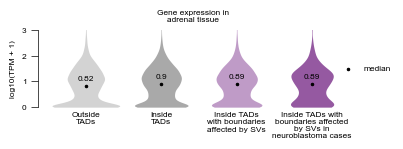

In [50]:
fig, ax = plt.subplots(1, 1, figsize = (4, 1))

violin = sns.violinplot(x = 'type', y = 'log10(TPM + 1)', data = grouped_data, ax = ax,
                        order = ['non_tad', 'tad', 'tad_sv_all', 'tad_sv_cases'], width = 0.9, linewidth=0, 
                        cut = 0, palette = pal)
    
tpms = []
for k, subset in enumerate(['non_tad', 'tad', 'tad_sv_all', 'tad_sv_cases']):
    cohort_data = grouped_data.query(f'type == "{subset}"')

    median = cohort_data['log10(TPM + 1)'].median()
    ax.scatter([k], [median], s = 3, color = 'black', label = 'median' if k == 0 else '')
    ax.text(s = np.round(median, 2), x = k, y = median + 0.3, va = 'center', ha = 'center')

ax.legend(bbox_to_anchor = (0.95, 0.5))
ax.set_ylim([0, 3])
ax.set_ylabel('log10(TPM + 1)')
aesthetics.strip_axis(ax = ax, x = 'label', y = 'ignore')
ax.set_title('Gene expression in\nadrenal tissue')
ax.set_xlabel('')
ax.set_xticklabels(['Outside\nTADs', 'Inside\nTADs', 'Inside TADs\nwith boundaries\naffected by SVs', 'Inside TADs with\nboundaries affected\nby SVs in\nneuroblastoma cases'])
fig.savefig('figures/revision-adrenal-tad-vs-nontad.png', dpi = 300, bbox_inches = 'tight')

In [51]:
tad = grouped_data.query(f'variable == "Adrenal Gland" & type == "tad"')['log10(TPM + 1)']
nontad = grouped_data.query(f'variable == "Adrenal Gland" & type == "non_tad"')['log10(TPM + 1)']
stats.mannwhitneyu(tad, nontad)

MannwhitneyuResult(statistic=38948884.0, pvalue=9.43693007920217e-14)

## Examine the tumor RNA

We established in the paper that noncoding SVs do not significantly impact the expression of their nearest gene. But what about TAD boundary SVs? Do genes in affected TADs get affected?

To do this, we need to extract the following data:

1. The SV in question
2. The sample affected by that SV
3. The TAD the SV affects
4. The genes in the TAD

Then for each gene in the TAD, we'll calculate the rank of the sample

In [52]:
# begin by extracting the case with the singleton SV
nbl_cases_w_singleton_svs = nbl_dosages_cases.loc[svs_in_cases['SV']]

affected_cases = []
for index, row in nbl_cases_w_singleton_svs.iterrows():
    row = row[row > 0]
    
    assert len(row) == 1
    
    affected_c = row.index[0]
    affected_cases.append(affected_c)

In [53]:
sv_sample_tad_gene_df = pd.DataFrame()
sv_sample_tad_gene_df['SV'] = svs_in_cases['SV']
sv_sample_tad_gene_df['affected_case'] = affected_cases

In [54]:
sv_sample_tad_gene_df.head(2)

,SV,affected_case
776730,PedSV.2.5.2_DEL_chr1_832,PT_HA7TBZ1V
776735,PedSV.2.5.2_DEL_chr1_1438,PT_NK39AFPG


Now, add in the affected TADs

In [55]:
affected_tads = []
for index, row in sv_sample_tad_gene_df.iterrows():
    sv = row['SV']
    
    affected_t = sv_tad_overlaps.query(f"analysis == 'cases' & name == '{sv}'")
    affected_tads.append(list(affected_t['tad']))
    
sv_sample_tad_gene_df['affected_tad'] = affected_tads
sv_sample_tad_gene_df = sv_sample_tad_gene_df.explode('affected_tad', ignore_index = True)

Now we add the affected genes

In [56]:
affected_genes = []
for index, row in sv_sample_tad_gene_df.iterrows():
    tad = row['affected_tad']
    
    affected_g = tad_locations.query(f"TAD_ID == '{tad}'")
    affected_genes.append(list(affected_g['gene']))
    
sv_sample_tad_gene_df['affected_gene'] = affected_genes
sv_sample_tad_gene_df = sv_sample_tad_gene_df.explode('affected_gene', ignore_index = True)

### Add in the RNA

This is a bit tedious, but we have generated this dataframe elsewhere.

In [57]:
rna_data = pd.read_csv('data/rna/gmkf_neuroblastoma_tpms.csv', index_col = 0)
cases_with_rna = [s for s in rna_data.columns if s in samples['neuroblastoma']['case']]

rna_data = rna_data[cases_with_rna]

In [58]:
# drop the samples that aren't in our RNA'
sv_sample_tad_gene_df = sv_sample_tad_gene_df[sv_sample_tad_gene_df['affected_case'].isin(rna_data.columns)]
sv_sample_tad_gene_df.head(2)

,SV,affected_case,affected_tad,affected_gene
0,PedSV.2.5.2_DEL_chr1_832,PT_HA7TBZ1V,TAD_1578,ARHGEF16
1,PedSV.2.5.2_DEL_chr1_832,PT_HA7TBZ1V,TAD_1578,MEGF6


Finally, we go through and just assess the rank

In [59]:
ranks = []
for index, row in sv_sample_tad_gene_df.iterrows():
    case, gene = row[['affected_case', 'affected_gene']]
    
    if gene not in rna_data.index:
        ranks.append(np.nan)
        continue
        
    gene_expression = rna_data.loc[gene]
    expression_ranks = (gene_expression.rank() - 1)
    norm_expression_ranks =  expression_ranks / (len(gene_expression) - 1)
    
    sample_rank = norm_expression_ranks.loc[case]
    ranks.append(sample_rank)
    
sv_sample_tad_gene_df['expression_rank'] = ranks

In [60]:
sv_sample_tad_gene_df = sv_sample_tad_gene_df.dropna()

And some quick stats:

In [61]:
rank_deviation = np.abs(0.5 - sv_sample_tad_gene_df['expression_rank'])

# calculate a p value - see methods of the paper
num_genes = len(sv_sample_tad_gene_df)
ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
p = 1 - ref_dist.cdf(rank_deviation.mean())
print(num_genes, 'p =', p, 'mean =', sv_sample_tad_gene_df['expression_rank'].mean())

85 p = 0.5289318533792257 mean = 0.5460561497326203


So no significant effect